# 3. Machine Learning

I attempted two different models to try to predict the number of users that own a stock based on its characteristics. The first model was a K-Nearest Neighbors model where I attempted to find the optimal prediction variables as well as the optimal value of K.

## KNN Model

The first step was to find which set of variables were the best predictors of Popularity of a stock, so as you can see below, I calculate the RMSE of different sets and calculated the RMSE of each one. I will then use whichever set of variables performs the best.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
vec = DictVectorizer(sparse=False)
model = KNeighborsRegressor(n_neighbors=10)

rh = pd.read_csv("final.csv").drop("Unnamed: 0", axis=1
            ).replace(True, 1).replace(False, 0)

pipeline = Pipeline([("vectorizer", vec),
    ("scaler", scaler), ("fit", model)])

features = list(rh.columns)
features.remove("Description")
features.remove("CEO_name")
features.remove("Ticker")
features.remove("Address")
rh_subset = rh.dropna()
X_dict = rh_subset.drop("Popularity", axis=1).to_dict(orient="records")
y = rh_subset["Popularity"]

baseline = np.sqrt(np.mean(-cross_val_score(pipeline,
        X_dict, y, cv=10, scoring="neg_mean_squared_error")))

feature_sets = [["MarketCap", "Consumer", "Energy", "Finance", "Manufacturing",
                 "Oil:Gas", "SocialMedia", "Software", "Tech", "Three_Month", "Month",
                "Five_Day", "Year", "Volume", "Price"], ["Price", "MarketCap", "Volume",
                'machine learning', 'artificial intelligence', 'robotics', 'gaming',
                'software', 'solar', 'cannabis', 'CEO_sex'], ["MarketCap", "Price",
                "Volume", "CEO_sex", "Tech", "Manufacturing", "Finance", "Oil:Gas"]]

for features in feature_sets:
    rh_subset = rh[features + ["Popularity"]].dropna()
    X_dict = rh_subset.drop("Popularity", axis=1).to_dict(orient="records")
    y = rh_subset["Popularity"]
    print(np.sqrt(np.mean(-cross_val_score(pipeline,
         X_dict, y, cv=10, scoring="neg_mean_squared_error"))))

29810.0378137
23441.2001355
21338.0894424


It looks like the best RMSE that was produced by a set of features was the third set, which produced an RMSE of 21,338. This was interesting because this was not necessarily the set of features that had the most variables included in it. The second set of features included the specific keywords that we looked for in the description and it actually had a worse RMSE compared to the feature set without they keywords, so we will leave them out of the model.

The next step is to find the optimal value of k for the lowest RMSE of our model. Below, I search for the lowest RMSE produced by k values between 1 and 30.

Test Errors:

6     4.462704e+08
10    4.511519e+08
9     4.545308e+08
7     4.581032e+08
8     4.634305e+08
11    4.642297e+08
dtype: float64


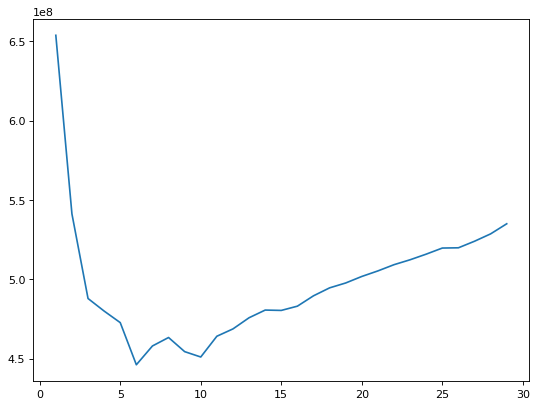

In [2]:
from matplotlib.pyplot import figure

scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=15)

predictors = ["MarketCap", "Price", "Volume", "CEO_sex", "Tech", "Manufacturing", "Finance", "Oil:Gas"]

rh_subset = rh[predictors + ["Popularity"]].dropna()

y = rh_subset["Popularity"]

X_dict = rh_subset.drop("Popularity", axis=1).to_dict(orient="records")

def get_test_error(k):
    model = KNeighborsRegressor(n_neighbors=k, metric="manhattan")
    pipeline = Pipeline([("vectorizer", vec),
    ("scaler", scaler), ("fit", model)])
    return (np.mean(-cross_val_score(pipeline, X_dict, y,
            cv=10, scoring="neg_mean_squared_error")))

ks = pd.Series(range(1, 30))
ks.index = range(1, 30)
test_errs = ks.apply(get_test_error)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

test_errs.plot.line()
print("Test Errors:")
print()
print(test_errs.sort_values()[:6])

From the chart above, we can see that the optimal value of k is about 6, so this is what we will use for the final version of our model.

Now that it is complete, this model could be applied to estimate the amount of Robinhood users who would invest in a stock if it was made available on the platform. They could use this model when looking at new stocks to add to see if the user demand would be worth the time in effort put in to add the stock to the system.

I found a company called Bombardier who are an aerospace manufacturer that specialize in manufacturing planes and other forms of transportation. Currently, their stock is not offered on Robinhood, but let's try to predict the amount of users who would want to invest in it if it was made available to them.

In [3]:
bombardier = pd.DataFrame({"MarketCap":[5240000],
              "Price":[2.12],
              "Finance":[0],
              "Manufacturing":[1],
              "Oil:Gas":[0],
              "Tech":[0],
              "Volume":[236690],
              "CEO_sex": [1]
})

vec.fit(X_dict)
X_train = vec.transform(X_dict)
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

bombardier_sc = scaler.transform(bombardier)

model = KNeighborsRegressor(n_neighbors=11)
model.fit(X_train_sc, y)
model.predict(bombardier_sc)[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


8440.0909090909099

According to the model, if Robinhood were to add Bombardier to their list of stocks offered, they could expect to have around 8440 users own that stock.

## Random Forest Model

The KNN model above is good for predicting the Popularity of stocks that are not currently listed on Robinhood, but I was also interested in predicting the Popularity of companies that do not even have publicly traded stocks. I decided to make a Random Forest model that only used the variables about a company that did not involve statistics about its stock by removing volume, price, historical changes, etc. This way, I would be able to get estimates for upcoming company IPOs.

First, I split up the data into a training and validation set so that I didn't train the model on data that it will use to predict popularity. Then I scaled all of the data to the training set.

In [4]:
company_info = rh[["MarketCap", "Consumer", "Energy", "Entertainment", "Finance", "Health",
                  "Manufacturing", "Oil:Gas", "SocialMedia", "Software", "Tech", "CEO_sex",
                  "CEO_age", "English_Word", "Popularity"]].dropna()

train = company_info.sample(frac=.75)
val = company_info.drop(train.index)

X_train = train.drop("Popularity", axis=1)
X_val = val.drop("Popularity", axis=1)

y_train = train["Popularity"]
y_val = val["Popularity"]

scaler = StandardScaler()

scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_val_sc = scaler.transform(X_val)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


Next, I used the RandomizedSearchCV function from scikit-learn to optimize the parameters of the Random Forest Regressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 3, stop = 40)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 30)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf,
                            param_distributions = random_grid, n_iter = 100, cv = 3,
                               verbose=2)

rf_random.fit(X_train_sc, y_train)

At the end of the optimization, I took the best model and fit the regressor to the training data. Then I used the new model to predict the popularity of the validation data.

In [6]:
best_random = rf_random.best_estimator_

print(best_random)

regressor = best_random
regressor.fit(X_train_sc, y_train)  
y_pred = regressor.predict(X_val_sc)

print('\nMean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred))) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=24, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Mean Absolute Error: 13417.9218797
Mean Squared Error: 978903799.824
Root Mean Squared Error: 31287.4383711


The RMSE of this model turned out to be 13,874, which is much better than our RMSE of 21,338 that we obtained from the KNN that I made earlier. Now we can predict the popularity of some upcoming IPOs. I researched the most anticipated IPOs of 2019 and found that Uber and Lyft were expected to participate in public offerings this year. I collected the variables necessary to predict their expected Popularity and used the Random Forest model that was just created to generate an output.

In [7]:
uber = pd.DataFrame({"MarketCap":[120000000],
              "Consumer":[0],
              "Energy":[0],
              "Entertainment":[0],
              "Finance":[0],
              "Health":[0],
              "Manufacturing":[236690],
              "Oil:Gas":[0],
              "SocialMedia":[0],
              "Software":[0],
              "Tech":[1],
              "CEO_sex":[0],
              "CEO_age":[49],
              "English_Word":[0]
})

lyft = pd.DataFrame({"MarketCap":[22000000],
              "Consumer":[0],
              "Energy":[0],
              "Entertainment":[0],
              "Finance":[0],
              "Health":[0],
              "Manufacturing":[0],
              "Oil:Gas":[0],
              "SocialMedia":[0],
              "Software":[0],
              "Tech":[1],
              "CEO_sex":[0],
              "CEO_age":[35],
              "English_Word":[0]
})

uber_sc = scaler.transform(uber)
lyft_sc = scaler.transform(lyft)
print("Uber Expected Popularity: ", regressor.predict(uber_sc)[0])
print("Lyft Expected Popularity: ", regressor.predict(lyft_sc)[0])

Uber Expected Popularity:  25285.2454757
Lyft Expected Popularity:  26985.2887522


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


We can see that Uber is expected to be more popular than Lyft with 29,326 users expected to purchase their stock, while 27,284 are expected to purchase Lyft's stock. (These numbers will vary each time the notebook is run since the parameters of the Random Forest model will be different, but they should be relatively close.)